
# Import Data

Importing AUDUSD data.

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

forex_symbol = "EURUSD"

forex_df = pd.read_csv('../../data/gen/{}_Daily_df.csv'.format(forex_symbol),
                       parse_dates=True,
                       index_col=0)
# Strip whitespace from column names
forex_df.columns = forex_df.columns.str.strip()
# Print
forex_df.head()


,timestamp,open,high,low,close,pre_close,p_change,pip_change
,,,,,,,,
4998,2001-04-11,0.8879,0.8914,0.8805,0.8866,0.8876,-0.001127,-11.266336
4997,2001-04-12,0.8868,0.8942,0.8833,0.8917,0.8866,0.005752,57.523122
4996,2001-04-13,0.8918,0.8935,0.8878,0.8886,0.8917,-0.003477,-34.765056
4995,2001-04-16,0.8891,0.8903,0.8828,0.8858,0.8886,-0.003151,-31.510241
4994,2001-04-17,0.8860,0.8910,0.8774,0.8821,0.8858,-0.004177,-41.770151



## Performing Backtests

Assuming trading with Leverage

1. Analysing Parameters
1. Prepare Parameters
1. Dfine a DataFrame to handle results
1. For Loops
1. Prepare Maps & Filters

## Analysing Parameters

To determine sensible slop & velocity range to run backtests on, slope & velocity needs to be analysed.

### Calculate Slope & Velocity

In [2]:

extra_df = forex_df.copy()
extra_df['slope'] = pd.Series(np.gradient(extra_df.close), extra_df.index, name='slope')
extra_df['velocity'] = pd.Series(np.gradient(extra_df.slope), extra_df.index, name='velocity')
# Print
extra_df.head()


,timestamp,open,high,low,close,pre_close,p_change,pip_change,slope,velocity
,,,,,,,,,,
4998,2001-04-11,0.8879,0.8914,0.8805,0.8866,0.8876,-0.001127,-11.266336,0.00510,-0.004100
4997,2001-04-12,0.8868,0.8942,0.8833,0.8917,0.8866,0.005752,57.523122,0.00100,-0.004025
4996,2001-04-13,0.8918,0.8935,0.8878,0.8886,0.8917,-0.003477,-34.765056,-0.00295,-0.002125
4995,2001-04-16,0.8891,0.8903,0.8828,0.8858,0.8886,-0.003151,-31.510241,-0.00325,0.001175
4994,2001-04-17,0.8860,0.8910,0.8774,0.8821,0.8858,-0.004177,-41.770151,-0.00060,0.004500



### Analysing Slope & Velocity


DescribeResult(nobs=4999, minmax=(-0.025599999999999956, 0.036599999999999966), mean=4.656931386277253e-05, variance=2.637118020482849e-05, skewness=-0.06090732735461528, kurtosis=3.0237634756716902)

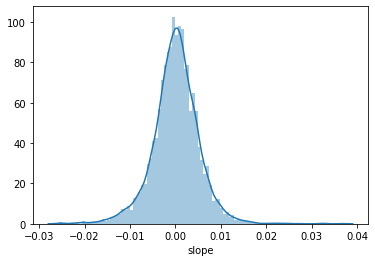

In [3]:

import seaborn as sns
from scipy import stats

sns.distplot(extra_df['slope'],
             bins=100,
             label="Daily Slope Change")
stats.describe(extra_df.slope)


DescribeResult(nobs=4999, minmax=(-0.03109999999999996, 0.022125000000000006), mean=-2.33546709341871e-06, variance=1.3435540637939523e-05, skewness=-0.07899131391593403, kurtosis=2.827657872625614)

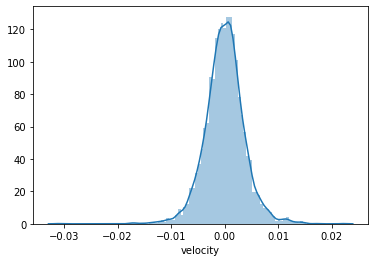

In [4]:

sns.distplot(extra_df['velocity'],
             bins=100,
             label="Daily Velocity Change")
stats.describe(extra_df.velocity)



## Preparing Parameters


In [5]:

import itertools

buy_slope_threshold_list = np.arange(extra_df.slope.mean() - extra_df.slope.std(), extra_df.slope.mean() + extra_df.slope.std(), extra_df.slope.std() * 2 / 5)
buy_velocity_threshold_list = np.arange(extra_df.velocity.mean() - extra_df.velocity.std(), extra_df.velocity.mean() + extra_df.velocity.std(), extra_df.velocity.std() * 2 / 5)
close_slope_threshold_list = np.arange(extra_df.slope.mean() - extra_df.slope.std(), extra_df.slope.mean() + extra_df.slope.std(), extra_df.slope.std() * 2 / 5)
close_velocity_threshold_list = np.arange(extra_df.velocity.mean() - extra_df.velocity.std(), extra_df.velocity.mean() + extra_df.velocity.std(), extra_df.velocity.std() * 2 / 5)
sell_slope_threshold_list = np.arange(extra_df.slope.mean() - extra_df.slope.std(), extra_df.slope.mean() + extra_df.slope.std(), extra_df.slope.std() * 2 / 5)
sell_velocity_threshold_list = np.arange(extra_df.velocity.mean() - extra_df.velocity.std(), extra_df.velocity.mean() + extra_df.velocity.std(), extra_df.velocity.std() * 2 / 5)

task_list = list(itertools.product(
    buy_slope_threshold_list, 
    buy_velocity_threshold_list, 
    close_slope_threshold_list, 
    close_velocity_threshold_list, 
    sell_slope_threshold_list, 
    sell_velocity_threshold_list
))
print("Backtest Params Ready, {} tasks to run. Will take about {} minutes to complete.".format(len(task_list), round(len(task_list)/(375*60), 2)))


Backtest Params Ready, 15625 tasks to run. Will take about 0.69 minutes to complete.



## Maths for Forex Margin Trading

### Without Leverage: 

Equity required to trade a standard lot of AUDUSD would be **AUD$100,000** converted to USD.

Assuming **1 pip rise** in price, aka 0.01%, aka 0.0001 change in price, will result calculate as $100,000 * 0.01% profit. **Profit = AUD$10 - SWAPs**.

Or simply **1 pip = $10 of the base currency**

Therefore, Return is AUD$10 / AUD$100,000 = **0.01%** (Or simply, 1 pip). 

**Return Fomula without Leverage** is therefore:

> Return = 1 pip * 1 = 0.01% = 0.0001 (p_change * 1)

The 1 means 1:1 Leverage, or no leverage.

### With Leverage:

Let's assume the following:

Leverage: 400

Equity required to trade a standard lot of AUDUSD would be AUD$100,000 / 400, or **AUD$250** converted to USD.

Assuming **1 pip rise** in price, aka 0.01%, aka 0.0001 change in price, will result calculate as $100,000 * 0.01% profit. **Profit = AUD$10 - SWAPs**.

Or simply **1 pip = $10 of the base currency**

Therefore, **Return Fomula with Leverage** is AUD$10 / AUD$250 = **4%** (or simply, 400 pip).

**Return Fomula without Leverage** is therefore:

> Return = 1 pip * 400 = 4% = 0.04 (p_change * 400)

The 400 means 1:400 Leverage. 

## Backtesting with 1:400 Leverage


In [6]:

import concurrent.futures
from concurrent.futures.process import ProcessPoolExecutor
from datetime import datetime
from tqdm import tqdm

# Trading Parameters
lots = 1 
leverage = 400 # 400 Leverage
margin_interest = 0.1 # 10% Margin Interest
pip_cost = 0.8 # Transaction Cost 0.8 pip
stop_loss = 2.0 # Stop Loss at 2.0 of standard deviation (so 5%)
one_trade_week = 6 # 6 Trade days a week for Forex
one_trade_month = one_trade_week * 4
two_trade_month = one_trade_month * 2
three_trade_month = one_trade_month * 3
half_trade_year = three_trade_month * 2
one_trade_year = half_trade_year * 2


In [15]:

backtest_df = forex_df[:-one_trade_year] # We use all available data until 2 years ago
    
# Defining a DataFrame to handle results
backtest_result = pd.DataFrame(columns=['buy_slope_threshold', 'buy_velocity_threshold', 'close_slope_threshold', 'close_velocity_threshold', 'sell_slope_threshold', 'sell_velocity_threshold', 'profit_percentage'])

def single_test(data_df, 
                t_lots,
                t_leverage,
                t_pip_cost,
                buy_slope_threshold, 
                buy_velocity_threshold, 
                close_slope_threshold, 
                close_velocity_threshold, 
                sell_slope_threshold, 
                sell_velocity_threshold):
            
        """
        Firstly, add `slope` and `velocity` columns to DataFrame
        """
        data_df['profit'] = 0
        data_df['slope'] = pd.Series(np.gradient(data_df.pre_close), data_df.index, name='slope') # Find the slope of yesterday, aka. pre_close
        data_df['velocity'] = pd.Series(np.gradient(data_df.slope), data_df.index, name='velocity')
        
        """
        Secondly, Closing
        """
        data_df['position'] = "CLOSE"
        
        """
        Thirdly, Buying
        """
        long_mask = (data_df.slope > buy_slope_threshold) & (data_df.velocity > buy_velocity_threshold)
        long_close = (data_df.slope < -close_slope_threshold) & (data_df.velocity < -close_velocity_threshold)
        data_df.loc[long_mask, 'position'] = "LONG"
        data_df.loc[long_mask, 'profit'] = (data_df.loc[long_mask, 'pip_change'] - t_pip_cost * 2) * t_lots * 10 # Assuming 2 transaction pip cost for buying and selling.
        # if stop_loss != 0:
            # TODO: Implement Stop Loss.
        
        """
        Finally, Selling
        """
        short_mask = (data_df.slope < sell_slope_threshold) & (data_df.velocity < sell_velocity_threshold)
        short_close = (data_df.slope > close_slope_threshold) & (data_df.velocity > close_velocity_threshold)
        data_df.loc[short_mask, 'position'] = "SHORT"
        data_df.loc[short_mask, 'profit'] = -(data_df.loc[short_mask, 'pip_change'] + t_pip_cost * 2) * t_lots * 10 # Assuming 2 transaction pip cost for buying and selling.
        # if stop_loss != 0:
            # TODO: Implement Stop Loss.
    
        test_result = [buy_slope_threshold, 
                       buy_velocity_threshold, 
                       close_slope_threshold, 
                       close_velocity_threshold, 
                       sell_slope_threshold, 
                       sell_velocity_threshold, 
                       data_df.profit.sum() / (lots * 100000 / t_leverage)]
        return test_result

start_time = datetime.now()

with ProcessPoolExecutor() as executor:
    """
    By default, ProcessPool uses maximum available number of cores to process.
    """
    
    """
    Equivalent to executor.map(fn, *iterables),
    but displays a tqdm-based progress bar.
    
    Does not support timeout or chunksize as executor.submit is used internally
    
    **kwargs is passed to tqdm.
    """
    futures_list = []
    kwargs = {
        'total': len(futures_list),
        'mininterval': 30.0,
        'unit': 'tests',
        'unit_scale': True,
        'leave': True
    }
        
    futures_list = [executor.submit(single_test, 
                                    backtest_df,
                                    lots,
                                    leverage,
                                    pip_cost,
                                    buy_slope_threshold, 
                                    buy_velocity_threshold, 
                                    close_slope_threshold, 
                                    close_velocity_threshold, 
                                    sell_slope_threshold, 
                                    sell_velocity_threshold) for buy_slope_threshold, \
                                                                 buy_velocity_threshold, \
                                                                 close_slope_threshold, \
                                                                 close_velocity_threshold, \
                                                                 sell_slope_threshold, \
                                                                 sell_velocity_threshold in task_list]
    print("Running {} tasks".format(len(futures_list)))
    
    for f in tqdm(concurrent.futures.as_completed(futures_list), **kwargs):
        # done_callback runs on the main process
        result_row = f.result()
        
        backtest_result = backtest_result.append(pd.Series(result_row, index=backtest_result.columns), ignore_index=True)

    print("Finished {} tasks in {}".format(len(task_list), datetime.now() - start_time))


15.6ktests [02:09, 120tests/s]


Running 15625 tasks
Finished 15625 tasks in 0:02:10.576258



## Analysing Backtest Results


In [16]:
        
backtest_result = backtest_result.sort_values(by=['profit_percentage'],
                                        ascending=False)
backtest_result.to_csv('../gen/StrategySV_{}_Daily_Backtest_Params_df.csv'.format(forex_symbol))
backtest_result.head()


,buy_slope_threshold,buy_velocity_threshold,close_slope_threshold,close_velocity_threshold,sell_slope_threshold,sell_velocity_threshold,profit_percentage
319,-0.005089,-0.003668,-0.000980,-0.000735,0.001074,0.002197,6007.911799
444,-0.005089,-0.003668,0.001074,-0.000735,0.001074,0.002197,6007.911799
242,-0.005089,-0.003668,-0.003035,0.002197,0.001074,0.002197,6007.911799
193,-0.005089,-0.003668,-0.003035,-0.000735,0.001074,0.002197,6007.911799
371,-0.005089,-0.003668,-0.000980,0.002197,0.001074,0.002197,6007.911799


In [19]:

backtest_result = pd.read_csv('../gen/StrategySV_{}_Daily_Backtest_Params_df.csv'.format(forex_symbol))

paper_df = forex_df[-one_trade_year:] # We use all available data until 2 years ago
paper_params = backtest_result.iloc[:1000]

test_list = list(zip(paper_params.buy_slope_threshold, 
                    paper_params.buy_velocity_threshold,
                    paper_params.close_slope_threshold, 
                    paper_params.close_velocity_threshold,
                    paper_params.sell_slope_threshold, 
                    paper_params.sell_velocity_threshold,))

print("Params Ready, {} tasks to run. ".format(len(test_list)))
    

Params Ready, 1000 tasks to run. 


In [20]:
# Defining a DataFrame to handle results
paper_result = pd.DataFrame(columns=['buy_slope_threshold', 'buy_velocity_threshold', 'close_slope_threshold', 'close_velocity_threshold', 'sell_slope_threshold', 'sell_velocity_threshold', 'profit_percentage'])

start_time = datetime.now()

with ProcessPoolExecutor() as executor:
    """
    By default, ProcessPool uses maximum available number of cores to process.
    """
    
    """
    Equivalent to executor.map(fn, *iterables),
    but displays a tqdm-based progress bar.
    
    Does not support timeout or chunksize as executor.submit is used internally
    
    **kwargs is passed to tqdm.
    """
    futures_list = []
    kwargs = {
        'total': len(futures_list),
        'mininterval': 30.0,
        'unit': 'tests',
        'unit_scale': True,
        'leave': True
    }
        
    futures_list = [executor.submit(single_test, 
                                    paper_df,
                                    lots,
                                    leverage,
                                    pip_cost,
                                    buy_slope_threshold, 
                                    buy_velocity_threshold, 
                                    close_slope_threshold, 
                                    close_velocity_threshold, 
                                    sell_slope_threshold, 
                                    sell_velocity_threshold) for buy_slope_threshold, \
                                                                 buy_velocity_threshold, \
                                                                 close_slope_threshold, \
                                                                 close_velocity_threshold, \
                                                                 sell_slope_threshold, \
                                                                 sell_velocity_threshold in test_list]
    print("Running {} tests".format(len(futures_list)))
    
    for f in tqdm(concurrent.futures.as_completed(futures_list), **kwargs):
        # done_callback runs on the main process
        result_row = f.result()
        
        paper_result = paper_result.append(pd.Series(result_row, index=paper_result.columns), ignore_index=True)

    print("Finished {} tests in {}".format(len(test_list), datetime.now() - start_time))


1.00ktests [00:03, 251tests/s]


Running 1000 tests
Finished 1000 tests in 0:00:04.123532



## Analysing Forward Test Results


In [21]:
        
paper_result = paper_result.sort_values(by=['profit_percentage'],
                                        ascending=False)
paper_result.to_csv('../gen/StrategySV_{}_Daily_PaperTest_Params_df.csv'.format(forex_symbol))
paper_result.head()


,buy_slope_threshold,buy_velocity_threshold,close_slope_threshold,close_velocity_threshold,sell_slope_threshold,sell_velocity_threshold,profit_percentage
413,-0.00098,-0.002202,0.001074,-0.003668,0.001074,0.000731,215.086135
424,-0.00098,-0.002202,0.003128,0.000731,0.001074,0.000731,215.086135
422,-0.00098,-0.002202,0.003128,-0.002202,0.001074,0.000731,215.086135
421,-0.00098,-0.002202,0.003128,0.002197,0.001074,0.000731,215.086135
419,-0.00098,-0.002202,0.001074,0.002197,0.001074,0.000731,215.086135



## Plotting Best Params

Plot the best trading result.

importing Jupyter notebook from strategy_sv.ipynb
Plotting 288 results for trade days
LONG 2018-07-19 - 2018-07-22
CLOSE 2018-07-23
SHORT 2018-07-23 - 2018-07-24
CLOSE 2018-07-25
LONG 2018-07-25 - 2018-07-26
SHORT 2018-07-26 - 2018-07-27
CLOSE 2018-07-29
LONG 2018-07-29 - 2018-07-31
CLOSE 2018-08-01
SHORT 2018-08-01 - 2018-08-03
CLOSE 2018-08-06
LONG 2018-08-06 - 2018-08-08
CLOSE 2018-08-09
SHORT 2018-08-09 - 2018-08-12
CLOSE 2018-08-13
LONG 2018-08-13 - 2018-08-14
SHORT 2018-08-14 - 2018-08-15
CLOSE 2018-08-16
LONG 2018-08-16 - 2018-08-22
CLOSE 2018-08-23
SHORT 2018-08-23 - 2018-08-24
LONG 2018-08-24 - 2018-08-29
CLOSE 2018-08-30
SHORT 2018-08-30 - 2018-09-02
CLOSE 2018-09-03
LONG 2018-09-03 - 2018-09-04
SHORT 2018-09-04 - 2018-09-05
LONG 2018-09-05 - 2018-09-06
CLOSE 2018-09-07
SHORT 2018-09-07 - 2018-09-09
CLOSE 2018-09-10
LONG 2018-09-10 - 2018-09-14
SHORT 2018-09-14 - 2018-09-16
CLOSE 2018-09-17
LONG 2018-09-17 - 2018-09-21
CLOSE 2018-09-23
SHORT 2018-09-23 - 2018-09-24
LONG 2018-

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


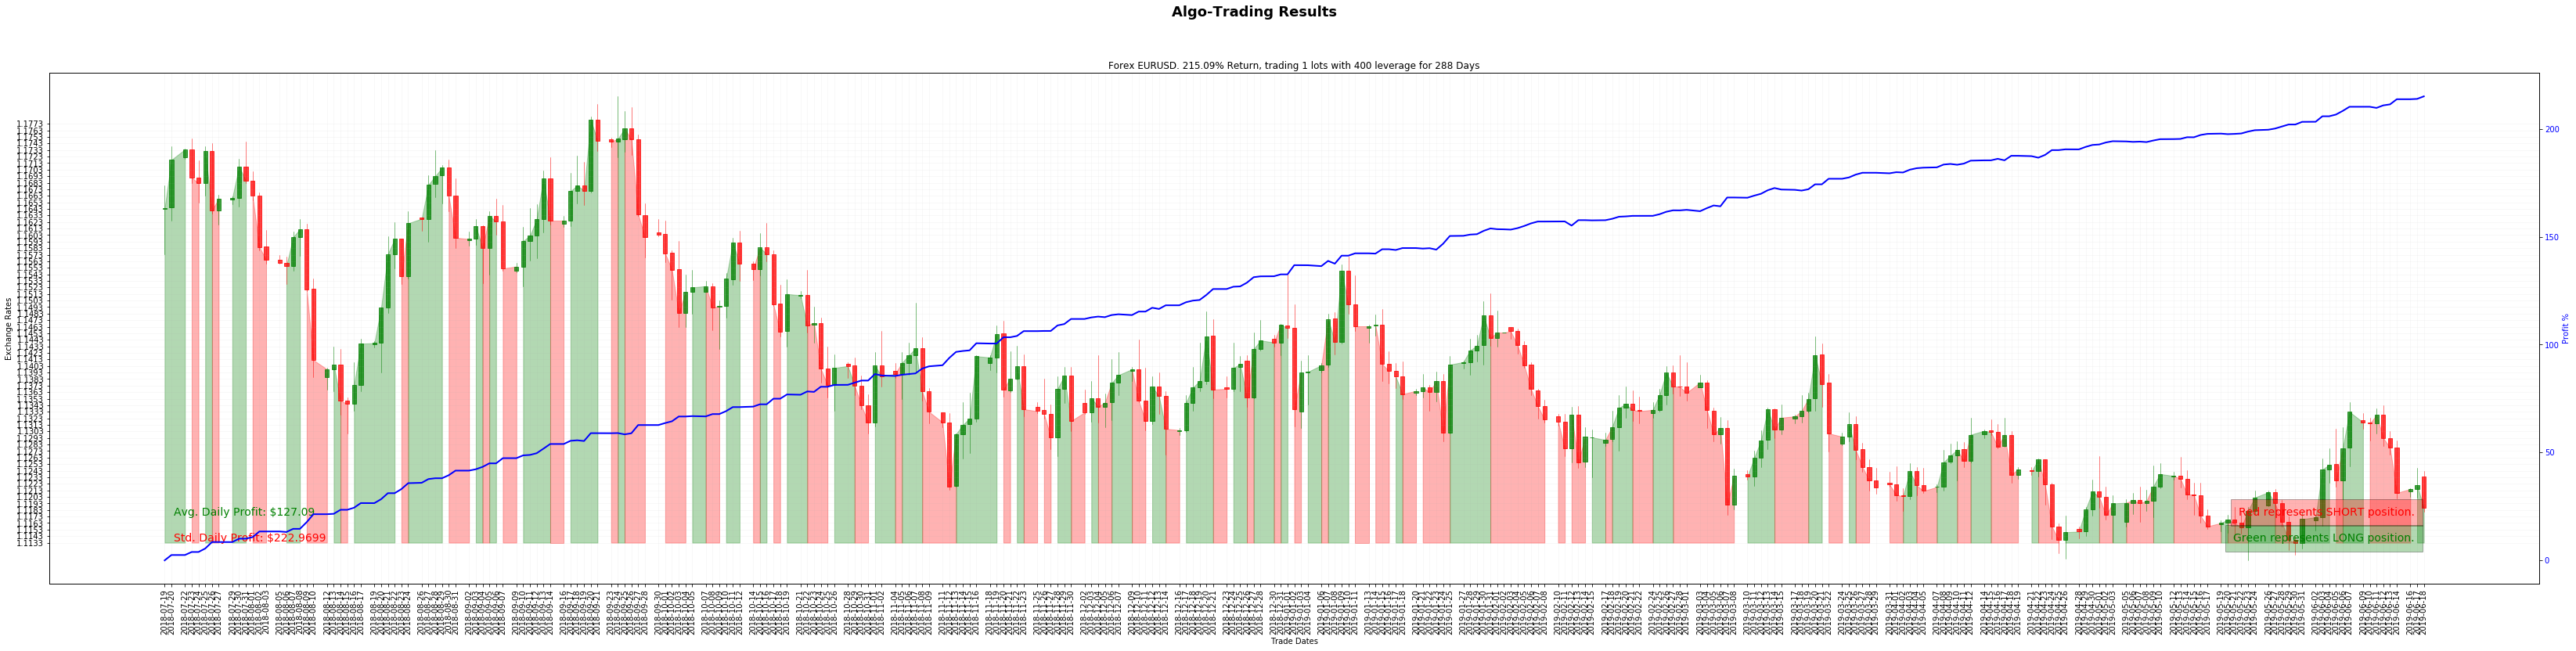

In [22]:

import import_ipynb
from strategy_sv import TradeStrategySV

paper_result = pd.read_csv('../gen/StrategySV_{}_Daily_PaperTest_Params_df.csv'.format(forex_symbol))

fig, axs = plt.subplots(figsize = (int(len(paper_df.index)/5),12))

fig.suptitle('Algo-Trading Results', fontsize=18, fontweight='bold')

best_strategy = TradeStrategySV(leverage=leverage,
                               margin=margin_interest,
                               pip_cost=pip_cost,
                               buy_slope_threshold=paper_result.buy_slope_threshold[1], 
                               buy_velocity_threshold=paper_result.buy_velocity_threshold[1], 
                               close_slope_threshold=paper_result.close_slope_threshold[1], 
                               close_velocity_threshold=paper_result.close_velocity_threshold[1], 
                               sell_slope_threshold=paper_result.sell_slope_threshold[1], 
                               sell_velocity_threshold=paper_result.sell_velocity_threshold[1], 
                               should_log=True)
forex_df = best_strategy.trade(data_df=paper_df, 
                              symbol=forex_symbol,
                              lots=lots,
                              stop_loss=stop_loss,)



best_strategy.plot_trade(axs=axs)

fig.savefig('../gen/StrategySV_{}_Daily.png'.format(forex_symbol), dpi=150, bbox_inches="tight")

print("In the latest {} trading days, StrategySV (Optimized) resulted ${}, or {}%".format(len(paper_df.index), round(best_strategy.trade_profit, 2), round(best_strategy.trade_profit/(lots * 100000 / leverage), 2)))
